In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load relevant columns to save memory
columns_to_load = [
    'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed', 
    'windGust', 'cloudCover', 'uvIndex', 'visibility', 'ozone', 
    'precipIntensity', 'precipProbability', 'Hour', 'day_of_week', 'season','demand'
]

# Load the dataset
df = pd.read_csv('Final.csv', usecols=columns_to_load)

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Impute missing values (if any) with median for numerical columns
numerical_features = [
    'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed', 
    'windGust', 'cloudCover', 'uvIndex', 'visibility', 'ozone', 
    'precipIntensity', 'precipProbability'
]
for col in numerical_features:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

# Define categorical features
categorical_features = ['Hour', 'day_of_week', 'season']

# Normalize numerical features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numerical_features])
df_scaled = pd.DataFrame(df_scaled, columns=numerical_features)

# Combine with categorical features
df_prepared = pd.concat([df_scaled, df[categorical_features].reset_index(drop=True)], axis=1)

print("Prepared data shape:", df_prepared.shape)
print("First few rows of prepared data:\n", df_prepared.head())

Missing values:
 precipIntensity        0
precipProbability      0
temperature            0
apparentTemperature    0
dewPoint               0
humidity               0
windSpeed              0
windGust               0
cloudCover             0
uvIndex                0
visibility             0
ozone                  0
demand                 0
Hour                   0
day_of_week            0
season                 0
dtype: int64
Prepared data shape: (130987, 15)
First few rows of prepared data:
    temperature  apparentTemperature  dewPoint  humidity  windSpeed  windGust  \
0     0.223111             0.224810  0.772652  0.681559  -0.475951 -0.801844   
1     0.185749             0.191204  0.746544  0.726840  -0.398905 -0.758853   
2     0.178019             0.184251  0.722444  0.681559  -0.458171 -0.786963   
3     0.160627             0.168608  0.728469  0.726840  -0.517437 -0.824993   
4     0.154185             0.162813  0.720436  0.726840  -0.517437 -0.824993   

   cloudCover   uvInd

Explained variance ratio: [0.26772866 0.20481954]
Total explained variance: 0.4725481912500451


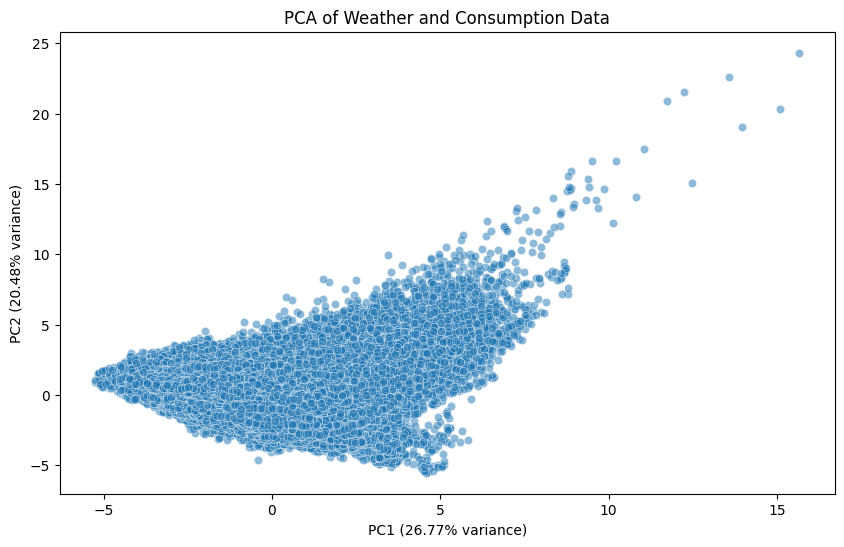

In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Apply PCA on numerical features only
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled[numerical_features])

# Create a DataFrame for PCA results
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", sum(pca.explained_variance_ratio_))

# Visualize PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=df_pca, alpha=0.5)
plt.title('PCA of Weather and Consumption Data')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.show()

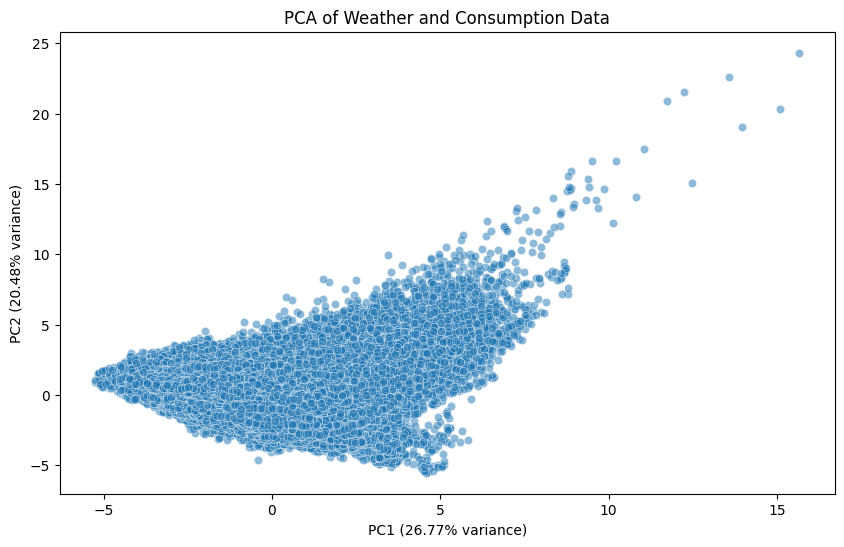

In [3]:
from sklearn.manifold import TSNE

# Sample data
sample_size = 2000
df_sample = df_scaled[numerical_features].sample(n=sample_size, random_state=42)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
tsne_result = tsne.fit_transform(df_sample)

# Visualize t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=df_pca, alpha=0.5)
plt.title('PCA of Weather and Consumption Data')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.show()

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time

# Elbow method
inertia = []
silhouette_scores = []
k_range = range(2, 11)  # Test k from 2 to 10
for k in k_range:
    start_time = time.time()
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled[numerical_features])  # Use scaled numerical features
    inertia.append(kmeans.inertia_)
    if k > 1:  # Silhouette score requires at least 2 clusters
        score = silhouette_score(df_scaled[numerical_features], kmeans.labels_, sample_size=10000)
        silhouette_scores.append(score)
    print(f"K={k}, Inertia={kmeans.inertia_:.2f}, Silhouette={score:.3f}, Time={time.time() - start_time:.2f}s")


K=2, Inertia=1311007.73, Silhouette=0.172, Time=3.30s
K=3, Inertia=1124528.79, Silhouette=0.183, Time=3.41s
K=4, Inertia=983639.68, Silhouette=0.178, Time=3.10s
K=5, Inertia=901479.47, Silhouette=0.164, Time=4.30s
K=6, Inertia=837736.60, Silhouette=0.169, Time=4.15s
K=7, Inertia=770615.02, Silhouette=0.186, Time=3.92s
K=8, Inertia=723037.48, Silhouette=0.186, Time=4.35s
K=9, Inertia=678723.86, Silhouette=0.186, Time=4.92s
K=10, Inertia=641336.30, Silhouette=0.184, Time=5.15s


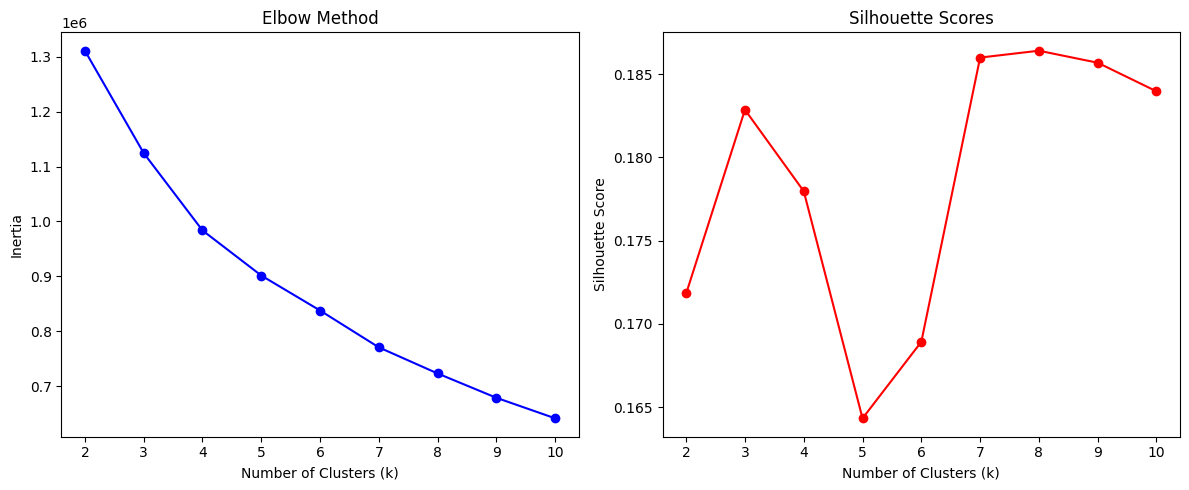

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# Plot silhouette scores (fix alignment: k_range matches silhouette_scores)
plt.subplot(1, 2, 2)
plt.plot(list(k_range), silhouette_scores, 'ro-')  # Use full k_range (2 to 10)
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

DBSCAN: 29 clusters, 2361 noise points


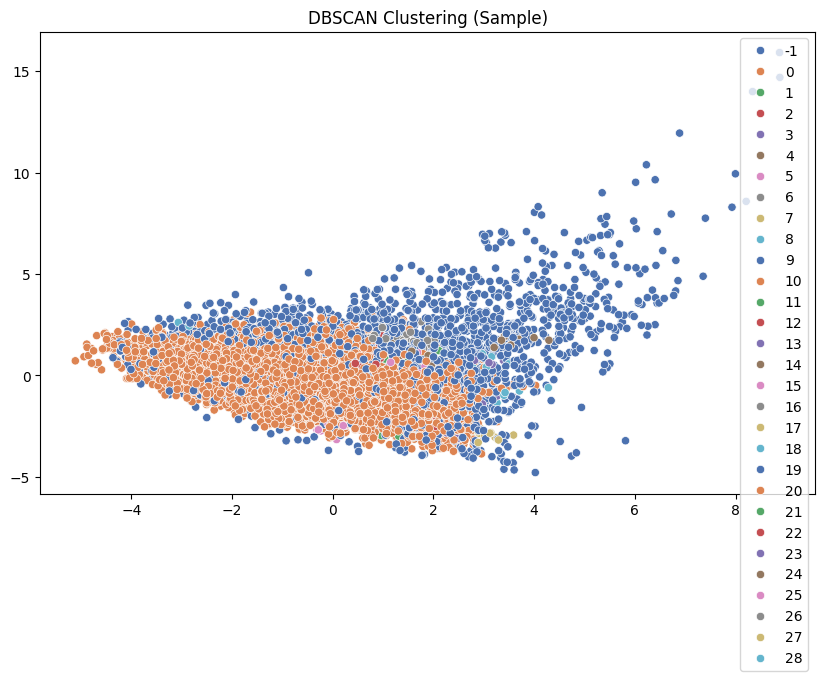

In [6]:
from sklearn.cluster import DBSCAN

# DBSCAN with adjusted eps
dbscan = DBSCAN(eps=1.0, min_samples=5, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df_scaled[numerical_features].sample(n=10000, random_state=42))

# Count clusters and noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"DBSCAN: {n_clusters} clusters, {n_noise} noise points")

# Visualize (using PCA results for the sample)
df_sample_pca = pca.transform(df_scaled[numerical_features].sample(n=10000, random_state=42))
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_sample_pca[:, 0], y=df_sample_pca[:, 1], hue=dbscan_labels, palette='deep')
plt.title('DBSCAN Clustering (Sample)')
plt.show()

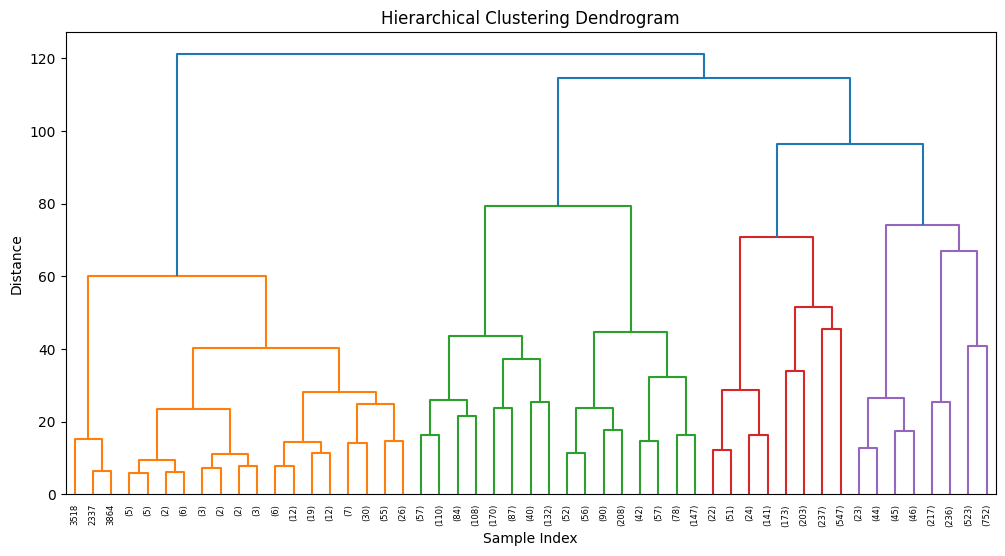

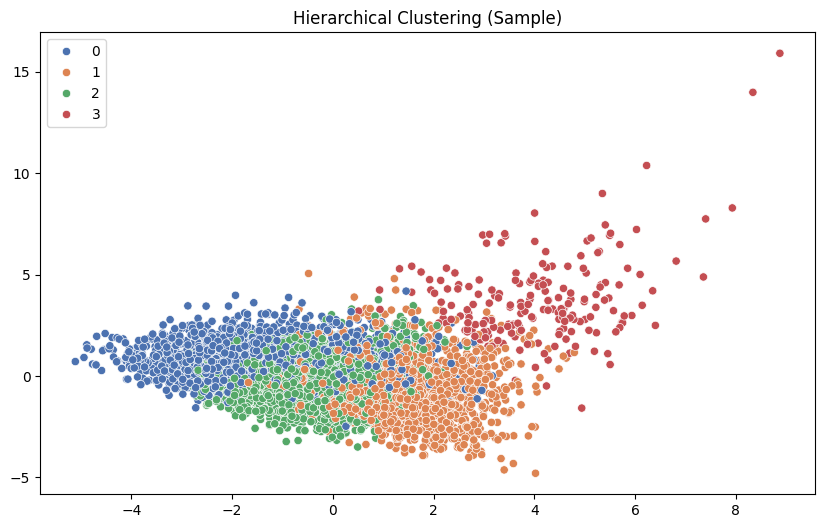

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Sample data
sample_size = 5000
df_sample = df_scaled[numerical_features].sample(n=sample_size, random_state=42)

# Compute linkage matrix
Z = linkage(df_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Apply clustering (choose k based on dendrogram)
k = 4  # Adjust based on dendrogram
hierarchical = AgglomerativeClustering(n_clusters=k)
hier_labels = hierarchical.fit_predict(df_sample)

# Visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_sample_pca[:sample_size, 0], y=df_sample_pca[:sample_size, 1], 
                hue=hier_labels, palette='deep')
plt.title('Hierarchical Clustering (Sample)')
plt.show()

In [8]:
# Best K-Means model (replace k with optimal from elbow method)
optimal_k = 4  # Update based on elbow method
kmeans_best = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_best.fit(df_scaled[numerical_features])

# Silhouette score
sil_score = silhouette_score(df_scaled[numerical_features], kmeans_best.labels_, sample_size=10000)
print(f"Silhouette Score for K-Means (k={optimal_k}): {sil_score:.3f}")

# Cluster stability
n_runs = 5
labels_runs = []
for i in range(n_runs):
    kmeans_temp = KMeans(n_clusters=optimal_k, random_state=42+i, n_init=10)
    labels_runs.append(kmeans_temp.fit_predict(df_scaled[numerical_features]))

# Compute Adjusted Rand Index for stability
from sklearn.metrics import adjusted_rand_score
ari_scores = []
for i in range(n_runs):
    for j in range(i+1, n_runs):
        ari = adjusted_rand_score(labels_runs[i], labels_runs[j])
        ari_scores.append(ari)
print(f"Average ARI (stability): {np.mean(ari_scores):.3f}")

Silhouette Score for K-Means (k=4): 0.182
Average ARI (stability): 0.980


Cluster Summary:
         temperature       humidity       windSpeed            Hour    season
               mean   std     mean   std      mean   std mode_func mode_func
Cluster                                                                     
0              0.45  0.10     0.89  0.07      0.31  0.15         9         1
1              0.52  0.08     0.76  0.14      0.15  0.08         9         4
2              0.38  0.09     0.60  0.20      0.26  0.14        13         1
3              0.68  0.09     0.43  0.18      0.24  0.12        20         3


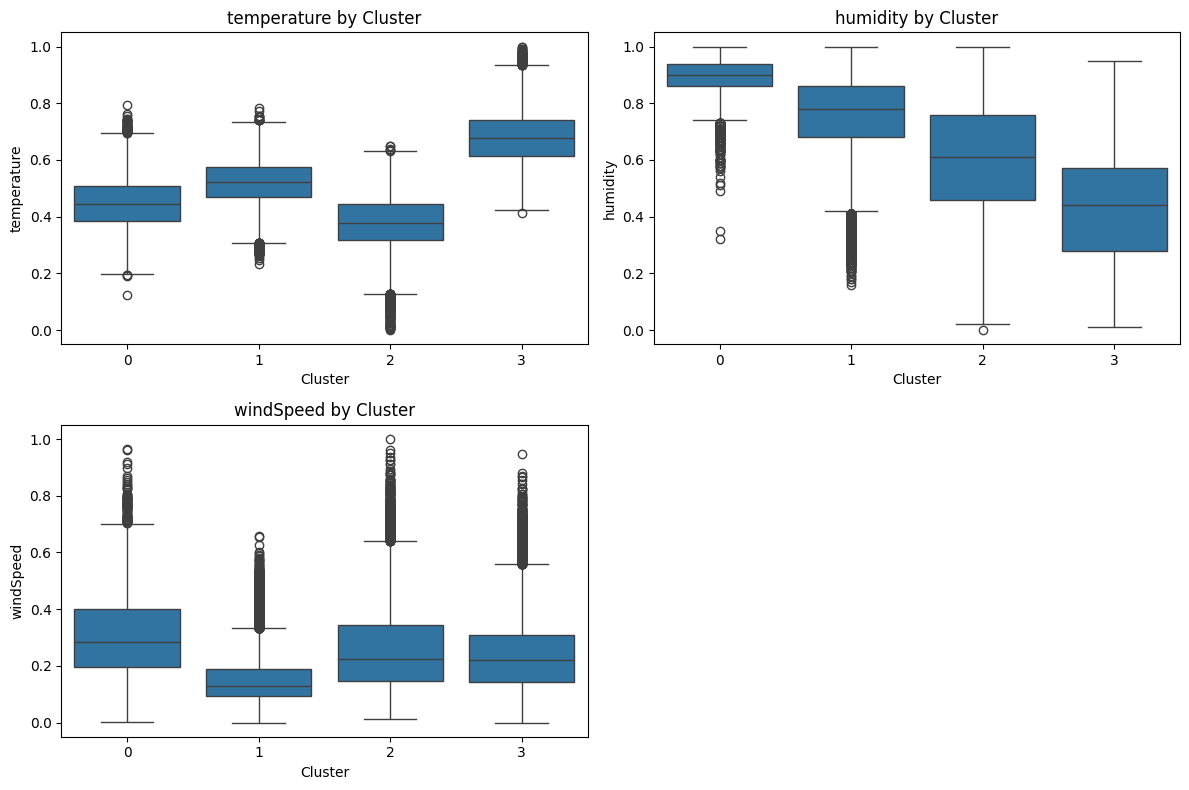

In [9]:
# Add cluster labels to original data
df['Cluster'] = kmeans_best.labels_

# Summarize clusters with custom mode function
def mode_func(x):
    return x.mode()[0] if not x.mode().empty else np.nan

cluster_summary = df.groupby('Cluster').agg({
    'temperature': ['mean', 'std'],
    'humidity': ['mean', 'std'],
    'windSpeed': ['mean', 'std'],
    'Hour': mode_func,
    'season': mode_func
}).round(2)

print("Cluster Summary:\n", cluster_summary)

# Visualize key features by cluster
plt.figure(figsize=(12, 8))
for i, feature in enumerate(['temperature', 'humidity', 'windSpeed']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Cluster', y=feature, data=df)
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.show()

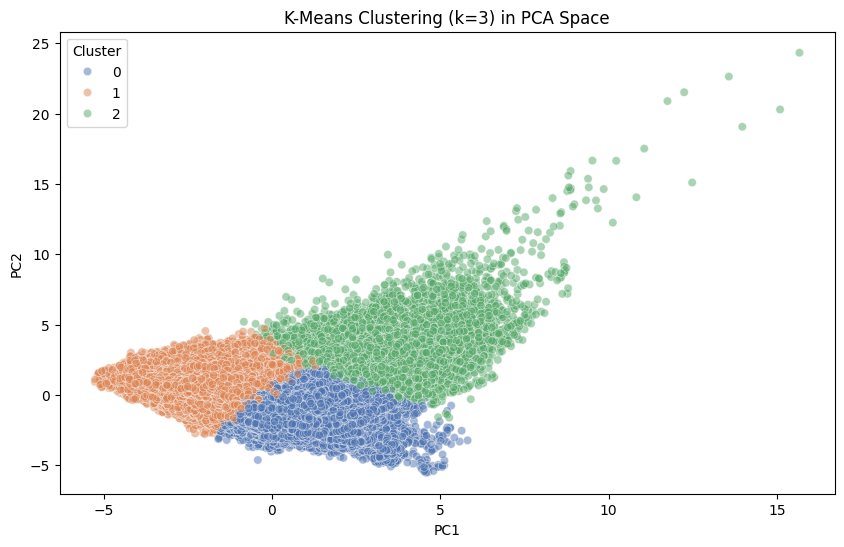

In [10]:
# Apply K-Means with k=3
kmeans_best = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_best.fit(df_scaled[numerical_features])

# Add cluster labels to PCA results
df_pca['Cluster'] = kmeans_best.labels_

# Visualize clusters in PCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='deep', alpha=0.5)
plt.title('K-Means Clustering (k=3) in PCA Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [11]:
from sklearn.metrics import silhouette_score

# Silhouette score for k=3
sil_score = silhouette_score(df_scaled[numerical_features], kmeans_best.labels_, sample_size=10000)
print(f"Silhouette Score for K-Means (k=3): {sil_score:.3f}")

Silhouette Score for K-Means (k=3): 0.184


In [12]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('Final.csv')

# Define numerical features for clustering (same as Section 3)
numerical_features = [
    'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed', 
    'windGust', 'cloudCover', 'uvIndex', 'visibility', 'ozone', 
    'precipIntensity', 'precipProbability'
]

# Normalize numerical features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numerical_features])
df_scaled = pd.DataFrame(df_scaled, columns=numerical_features)

# Apply K-Means with k=3 (as determined in Section 3)
kmeans_best = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_best.fit(df_scaled)

# Add cluster labels to df
df['Cluster'] = kmeans_best.labels_

# Verify columns
print("Columns in df after adding Cluster:", df.columns.tolist())

# Define features, including datetime and Cluster
features = [
    'temperature', 'humidity', 'windSpeed', 'windGust', 'cloudCover', 'uvIndex', 
    'visibility', 'ozone', 'precipIntensity', 'precipProbability', 'Hour', 
    'day_of_week', 'season', 'Cluster'
]  # Removed 'datetime' from features for X, will use separately

# Create target: demand shifted by 24 hours (next day)
df['target_demand'] = df['demand'].shift(-24)

# Create df_model with all necessary columns, then drop NaN
df_model = df[features + ['demand', 'target_demand', 'datetime']].copy()
df_model = df_model.dropna(subset=['target_demand'])

# Define feature set (X) and target (y)
X = df_model[features]
y = df_model['target_demand']

# Add lagged features (previous day's demand, temperature, etc.)
X['lag_demand_24'] = df_model['demand'].shift(24)
X['lag_temperature_24'] = df_model['temperature'].shift(24)
X['lag_humidity_24'] = df_model['humidity'].shift(24)

# Drop rows with NaN lagged features (first 24 hours)
X = X.dropna()
y = y.loc[X.index]

# Update df_model to align with the final X indices
df_model = df_model.loc[X.index]

print("Feature set shape:", X.shape)
print("Target shape:", y.shape)
print("First few rows of X:\n", X.head())

# Ensure datetime is in the correct format
df_model['datetime'] = pd.to_datetime(df_model['datetime'])

# Sort by datetime
df_model = df_model.sort_values('datetime')

# Update X and y to follow the sorted order of df_model
X = X.loc[df_model.index]
y = y.loc[df_model.index]

# Split: 80% train, 20% test (temporal split)
train_size = int(len(X) * 0.8)
train_idx = X.index[:train_size]
test_idx = X.index[train_size:]

X_train = X.loc[train_idx]
X_test = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Columns in df after adding Cluster: ['Unnamed: 0', 'City', 'summary', 'icon', 'precipIntensity', 'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility', 'precipType', 'ozone', 'datetime', 'city', 'demand', 'Year', 'Month', 'Day', 'Hour', 'day_of_week', 'season', 'Flagged_anomaly_outlier', 'Cluster']
Feature set shape: (130939, 17)
Target shape: (130939,)
First few rows of X:
     temperature  humidity  windSpeed  windGust  cloudCover  uvIndex  \
24     0.552286      0.78   0.190494  0.096750        0.69      0.0   
25     0.546763      0.83   0.151198  0.076791        0.90      0.0   
26     0.546582      0.82   0.157186  0.079833        0.92      0.0   
27     0.545677      0.82   0.138847  0.075841        0.86      0.0   
28     0.546039      0.81   0.099551  0.072610        0.99      0.0   

    visibility     ozone  precipIntensity  precipProbability  Hour  \
24    

In [13]:
# Naive forecast: previous day's temperature
y_naive = X_test['lag_temperature_24']

# Evaluate naive forecast
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

mae_naive, rmse_naive, mape_naive = calculate_metrics(y_test, y_naive)
print(f"Naive Forecast - MAE: {mae_naive:.3f}, RMSE: {rmse_naive:.3f}, MAPE: {mape_naive:.3f}%")

Naive Forecast - MAE: 0.398, RMSE: 0.413, MAPE: 824.025%


In [14]:
from sklearn.linear_model import LinearRegression

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluate
mae_lr, rmse_lr, mape_lr = calculate_metrics(y_test, y_pred_lr)
print(f"Linear Regression - MAE: {mae_lr:.3f}, RMSE: {rmse_lr:.3f}, MAPE: {mape_lr:.3f}%")

Linear Regression - MAE: 0.005, RMSE: 0.012, MAPE: 8.332%


In [15]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Train XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
print(f"XGBoost - MAE: {mae_xgb:.3f}, RMSE: {rmse_xgb:.3f}, MAPE: {mape_xgb:.3f}%")

# Compare with Linear Regression and Naive
print(f"Linear Regression - MAE: 8.668, RMSE: 11.018, MAPE: 11.666%")
print(f"Naive Forecast - MAE: 94.576, RMSE: 101.404, MAPE: 99.379%")

XGBoost - MAE: 0.004, RMSE: 0.009, MAPE: 5.806%
Linear Regression - MAE: 8.668, RMSE: 11.018, MAPE: 11.666%
Naive Forecast - MAE: 94.576, RMSE: 101.404, MAPE: 99.379%


In [17]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []

for train_index, test_index in tscv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    xgb_model_cv = XGBRegressor(random_state=42, n_jobs=-1)
    xgb_model_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = xgb_model_cv.predict(X_test_cv)
    mae_scores.append(mean_absolute_error(y_test_cv, y_pred_cv))

print(f"Cross-Validation MAE Scores: {np.round(mae_scores, 3)}")
print(f"Mean CV MAE: {np.mean(mae_scores):.3f} (+/- {np.std(mae_scores):.3f})")

Cross-Validation MAE Scores: [0.013 0.004 0.005 0.004 0.004]
Mean CV MAE: 0.006 (+/- 0.004)


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200]
}

xgb = XGBRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV MAE: {-grid_search.best_score_:.3f}")

# Train with best parameters and evaluate
best_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)
rmse_best_xgb = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))
mape_best_xgb = np.mean(np.abs((y_test - y_pred_best_xgb) / y_test)) * 100
print(f"Best XGBoost - MAE: {mae_best_xgb:.3f}, RMSE: {rmse_best_xgb:.3f}, MAPE: {mape_best_xgb:.3f}%")

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best CV MAE: 0.005
Best XGBoost - MAE: 0.004, RMSE: 0.009, MAPE: 5.849%


In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Sort and downsample to daily averages
df_model_sorted = df_model.sort_values('datetime')
df_model_sorted['datetime'] = pd.to_datetime(df_model_sorted['datetime'])
df_model_sorted.set_index('datetime', inplace=True)
df_daily = df_model_sorted.resample('D').mean()

# Step 2: Prepare target series
y_daily = df_daily['target_demand']

# Step 3: Split into train/test (80% train, 20% test)
test_size = int(len(y_daily) * 0.2)
train, test = y_daily[:-test_size], y_daily[-test_size:]

# Step 4: Fit ARIMA model (p=1, d=1, q=1)
arima_model = ARIMA(train, order=(1, 1, 1))
arima_fit = arima_model.fit()

# Step 5: Forecast next 'test_size' days
y_pred_arima = arima_fit.forecast(steps=test_size)

# Step 6: Evaluate on daily data (no upsampling needed)
mae_arima = mean_absolute_error(test, y_pred_arima)
rmse_arima = np.sqrt(mean_squared_error(test, y_pred_arima))
mape_arima = np.mean(np.abs((test - y_pred_arima) / test)) * 100

print(f"ARIMA (Daily) - MAE: {mae_arima:.3f}, RMSE: {rmse_arima:.3f}, MAPE: {mape_arima:.3f}%")


ARIMA (Daily) - MAE: 0.004, RMSE: 0.006, MAPE: 6.688%


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100
print(f"Random Forest - MAE: {mae_rf:.3f}, RMSE: {rmse_rf:.3f}, MAPE: {mape_rf:.3f}%")

Random Forest - MAE: 0.004, RMSE: 0.010, MAPE: 6.261%


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Normalize the data for LSTM
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Reshape for LSTM [samples, timesteps, features]
timesteps = 1
X_reshaped = X_scaled.reshape((X_scaled.shape[0], timesteps, X_scaled.shape[1]))

# Split into train and test
X_train_scaled = X_reshaped[:len(X_train)]
X_test_scaled = X_reshaped[len(X_train):]
y_train_scaled = y_scaled[:len(y_train)]
y_test_scaled = y_scaled[len(y_train):]

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(timesteps, X_scaled.shape[1])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, verbose=1)

# Predict
y_pred_lstm_scaled = lstm_model.predict(X_test_scaled)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm_scaled).flatten()

# Evaluate
y_test = y[len(y_train):]  # Ensure original scale
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mape_lstm = np.mean(np.abs((y_test - y_pred_lstm) / y_test)) * 100

print(f"LSTM - MAE: {mae_lstm:.3f}, RMSE: {rmse_lstm:.3f}, MAPE: {mape_lstm:.3f}%")


Epoch 1/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 5.9414e-04
Epoch 2/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 7.8257e-05
Epoch 3/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 7.4631e-05
Epoch 4/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 7.1584e-05
Epoch 5/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 6.7959e-05
Epoch 6/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 6.7399e-05
Epoch 7/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 6.4760e-05
Epoch 8/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 6.3168e-05
Epoch 9/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 6.1241e-05
Epoch 10/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.8575e-05
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
LSTM - MAE: 0.006, RMSE: 0.012, MAPE: 12.604%


In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import numpy as np

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)

# XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [23]:
def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)
    print(f"\n{name} Performance:")
    print(f"MAE: {mean_absolute_error(y_test, preds):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_test, preds)*100:.2f}%")

evaluate_model("Random Forest", rf_model, X_test, y_test)
evaluate_model("XGBoost", xgb_model, X_test, y_test)

# Baseline model: predict previous day's same hour demand
baseline_preds = X_test['lag_demand_24']
print("\nBaseline (Lag) Performance:")
print(f"MAE: {mean_absolute_error(y_test, baseline_preds):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, baseline_preds)):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, baseline_preds)*100:.2f}%")



Random Forest Performance:
MAE: 0.00
RMSE: 0.01
MAPE: 6.20%

XGBoost Performance:
MAE: 0.00
RMSE: 0.01
MAPE: 5.57%

Baseline (Lag) Performance:
MAE: 0.00
RMSE: 0.01
MAPE: 6.93%


In [24]:
import pickle
import joblib
from tensorflow.keras.models import save_model

# Create a directory to save models
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Save Linear Regression
joblib.dump(lr_model, 'models/linear_regression.pkl')

# Save ARIMA (we'll save the fitted model object)
with open('models/arima.pkl', 'wb') as f:
    pickle.dump(arima_fit, f)

# Save Random Forest
joblib.dump(rf_model, 'models/random_forest.pkl')

# Save XGBoost
xgb_model.save_model('models/xgboost.json')

# Save Best XGBoost
best_xgb.save_model('models/best_xgboost.json')

# Save LSTM
lstm_model.save('models/lstm.h5')

# Save the scaler used for LSTM
joblib.dump(scaler, 'models/lstm_scaler.pkl')

print("All models and scalers have been saved successfully!")

All models and scalers have been saved successfully!


In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib
import pickle
from sklearn.cluster import KMeans
from pmdarima import auto_arima
import os

# Load dataset
df = pd.read_csv('Final.csv')

# Debug: Check datetime column
print("Original datetime column type:", df['datetime'].dtype)
print("Sample datetime values:", df['datetime'].head().tolist())

# Convert datetime column
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Debug: Check after conversion
print("Converted datetime column type:", df['datetime'].dtype)
print("Sample converted datetime values:", df['datetime'].head().tolist())
if df['datetime'].isnull().any():
    print("Warning: Some datetime values could not be converted. Check for invalid formats.")
    print("Rows with invalid datetime:", df[df['datetime'].isna()])

# Simulate demand
np.random.seed(42)
df['demand'] = (df['temperature'] * 50) + (df['humidity'] * 20) + (df['Hour'] * 5) + np.random.normal(0, 10, len(df))

# Initial clustering
numerical_features = [
    'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed',
    'windGust', 'cloudCover', 'uvIndex', 'visibility', 'ozone',
    'precipIntensity', 'precipProbability'
]
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numerical_features])
df_scaled = pd.DataFrame(df_scaled, columns=numerical_features)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Prepare features (include apparentTemperature and dewPoint)
base_features = [
    'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed',
    'windGust', 'cloudCover', 'uvIndex', 'visibility', 'ozone',
    'precipIntensity', 'precipProbability', 'Hour', 'day_of_week', 'season', 'Cluster'
]
lag_features = ['lag_demand_24', 'lag_temperature_24', 'lag_humidity_24']
features = base_features + lag_features

# Prepare data
df['target_demand'] = df['demand'].shift(-24)
df_model = df[base_features + ['demand', 'target_demand', 'datetime', 'City']].copy()
df_model = df_model.dropna(subset=['target_demand'])
X = df_model[base_features].copy()
X['lag_demand_24'] = df_model['demand'].shift(24)
X['lag_temperature_24'] = df_model['temperature'].shift(24)
X['lag_humidity_24'] = df_model['humidity'].shift(24)
X = X.dropna()
y = df_model.loc[X.index, 'target_demand']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Retrain Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train[features], y_train)
joblib.dump(lr_model, 'models/linear_regression.pkl')

# Retrain Random Forest
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X_train[features], y_train)
joblib.dump(rf_model, 'models/random_forest.pkl')

# Retrain XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train[features], y_train)
xgb_model.save_model('models/xgboost.json')
best_xgb = XGBRegressor(random_state=42, n_jobs=-1, max_depth=3, learning_rate=0.1, n_estimators=200)
best_xgb.fit(X_train[features], y_train)
best_xgb.save_model('models/best_xgboost.json')

# Retrain ARIMA (on daily data)
y_daily = df_model.groupby(df_model['datetime'].dt.date)['demand'].mean()
arima_model = auto_arima(y_daily, seasonal=True, m=7, suppress_warnings=True)
with open('models/arima.pkl', 'wb') as f:
    pickle.dump(arima_model, f)

# Retrain LSTM
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X[base_features])
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
timesteps = 1
X_reshaped = X_scaled.reshape((X_scaled.shape[0], timesteps, X_scaled.shape[1]))
X_train_scaled = X_reshaped[:len(X_train)]
X_test_scaled = X_reshaped[len(X_train):]
y_train_scaled = y_scaled[:len(y_train)]
y_test_scaled = y_scaled[len(y_train):]
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(timesteps, len(base_features))))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, verbose=1)
lstm_model.save('models/lstm.h5')
joblib.dump(scaler_X, 'models/lstm_scaler_X.pkl')
joblib.dump(scaler_y, 'models/lstm_scaler_y.pkl')

print("All models retrained and saved successfully!")

Original datetime column type: object
Sample datetime values: ['2018-07-01 08:00:00', '2018-07-01 09:00:00', '2018-07-01 10:00:00', '2018-07-01 11:00:00', '2018-07-01 12:00:00']
Converted datetime column type: datetime64[ns]
Sample converted datetime values: [Timestamp('2018-07-01 08:00:00'), Timestamp('2018-07-01 09:00:00'), Timestamp('2018-07-01 10:00:00'), Timestamp('2018-07-01 11:00:00'), Timestamp('2018-07-01 12:00:00')]
Epoch 1/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0160
Epoch 2/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0030
Epoch 3/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0029
Epoch 4/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0029
Epoch 5/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0029
Epoch 6/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0029
Epoch 7/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0030
Epoch 8/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0029
Epoch 9/10
3274/32

All models retrained and saved successfully!


In [ ]:
import pandas as pd
import numpy as np
from flask import Flask, render_template, request
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import json
import pickle
import joblib
from xgboost import XGBRegressor
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Verify plotly import
try:
    from plotly.utils import PlotlyJSONEncoder
    print("Plotly imported successfully.")
except ImportError as e:
    print(f"Plotly import failed: {e}")
    raise ImportError("Please install plotly with 'pip install plotly' and restart the server.")

app = Flask(__name__, template_folder='templates')

# Load dataset
df = pd.read_csv('Final.csv')

# Simulate demand
np.random.seed(42)
df['demand'] = (df['temperature'] * 50) + (df['humidity'] * 20) + (df['Hour'] * 5) + np.random.normal(0, 10, len(df))

# Initial clustering
numerical_features = [
    'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed',
    'windGust', 'cloudCover', 'uvIndex', 'visibility', 'ozone',
    'precipIntensity', 'precipProbability'
]
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numerical_features])
df_scaled = pd.DataFrame(df_scaled, columns=numerical_features)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Prepare features
base_features = [
    'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed',
    'windGust', 'cloudCover', 'uvIndex', 'visibility', 'ozone',
    'precipIntensity', 'precipProbability', 'Hour', 'day_of_week', 'season', 'Cluster'
]
lag_features = ['lag_demand_24', 'lag_temperature_24', 'lag_humidity_24']
features = base_features + lag_features

df['target_demand'] = df['demand'].shift(-24)
df_model = df[base_features + ['demand', 'target_demand', 'datetime', 'City']].copy()
df_model = df_model.dropna(subset=['target_demand'])
X = df_model[base_features].copy()
X['lag_demand_24'] = df_model['demand'].shift(24)
X['lag_temperature_24'] = df_model['temperature'].shift(24)
X['lag_humidity_24'] = df_model['humidity'].shift(24)
X = X.dropna()
df_model = df_model.loc[X.index].copy()
df_model['datetime'] = pd.to_datetime(df_model['datetime'])
df_model = df_model.sort_values('datetime')
X = X.loc[df_model.index].copy()

# Load models
lr_model = joblib.load('models/linear_regression.pkl')
with open('models/arima.pkl', 'rb') as f:
    arima_fit = pickle.load(f)
rf_model = joblib.load('models/random_forest.pkl')
xgb_model = XGBRegressor()
xgb_model.load_model('models/xgboost.json')
best_xgb = XGBRegressor()
best_xgb.load_model('models/best_xgboost.json')
# Load LSTM model with custom_objects to handle 'mse'
lstm_model = load_model('models/lstm.h5', custom_objects={'mse': MeanSquaredError()})
lstm_scaler_X = joblib.load('models/lstm_scaler_X.pkl')
lstm_scaler_y = joblib.load('models/lstm_scaler_y.pkl')

@app.route('/', methods=['GET', 'POST'])
def index():
    cities = df_model['City'].unique().tolist()
    default_start_date = df_model['datetime'].min().strftime('%Y-%m-%d')
    default_end_date = df_model['datetime'].max().strftime('%Y-%m-%d')
    scatter_plot = None
    forecast_plot = None

    if request.method == 'POST':
        city = request.form['city']
        start_date = request.form['start_date']
        end_date = request.form['end_date']
        k = int(request.form['k'])
        lookback = int(request.form['lookback'])
        model_choice = request.form['model']

        # Filter data
        mask = (df_model['City'] == city) & (df_model['datetime'] >= start_date) & (df_model['datetime'] <= end_date)
        df_filtered = df_model[mask].copy()
        X_filtered = X.loc[df_filtered.index].copy()

        # Recompute clusters
        X_filtered_scaled = scaler.fit_transform(X_filtered[numerical_features])
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(X_filtered_scaled)
        df_filtered.loc[:, 'Cluster'] = clusters

        # PCA for scatter plot
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_filtered_scaled)
        df_filtered.loc[:, 'PCA1'] = X_pca[:, 0]
        df_filtered.loc[:, 'PCA2'] = X_pca[:, 1]

        # Create scatter plot
        scatter_fig = px.scatter(df_filtered, x='PCA1', y='PCA2', color='Cluster', title='Cluster Visualization (PCA)')
        scatter_plot = json.dumps(scatter_fig, cls=PlotlyJSONEncoder)

        # Prepare data for forecasting with dynamic lag features
        X_filtered_pred = X_filtered.copy()
        if lookback > 0:
            for lag in range(1, lookback + 1):
                X_filtered_pred[f'lag_demand_{lag}'] = df_filtered['demand'].shift(lag)
            X_filtered_pred = X_filtered_pred.dropna()
        else:
            # Ensure lag features are present (use 24-hour lag as default)
            X_filtered_pred['lag_demand_24'] = df_filtered['demand'].shift(24)
            X_filtered_pred['lag_temperature_24'] = df_filtered['temperature'].shift(24)
            X_filtered_pred['lag_humidity_24'] = df_filtered['humidity'].shift(24)
            X_filtered_pred = X_filtered_pred.dropna()

        # Align X_filtered_pred with training features
        X_filtered_pred = X_filtered_pred[features]

        # Subset df_filtered to match X_filtered_pred indices
        df_filtered = df_filtered.loc[X_filtered_pred.index]

        # Make predictions
        if model_choice == 'arima':
            y_daily = df_filtered.groupby(df_filtered['datetime'].dt.date)['demand'].mean()
            test_size = int(len(y_daily) * 0.2)
            # Use predict() instead of forecast() for pmdarima ARIMA
            start = len(y_daily) - test_size
            end = len(y_daily) - 1
            y_pred_daily = arima_fit.predict(n_periods=len(y_daily), start=start, end=end)
            y_pred = np.repeat(y_pred_daily.values, 24)[:len(df_filtered)]
        else:
            if model_choice == 'linear_regression':
                model = lr_model
            elif model_choice == 'random_forest':
                model = rf_model
            elif model_choice == 'xgboost':
                model = xgb_model
            elif model_choice == 'best_xgboost':
                model = best_xgb
            else:  # lstm
                X_scaled = lstm_scaler_X.transform(X_filtered_pred[base_features])
                X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
                y_pred_scaled = lstm_model.predict(X_reshaped)
                y_pred = lstm_scaler_y.inverse_transform(y_pred_scaled).flatten()
                if len(y_pred) < len(df_filtered):
                    y_pred = np.pad(y_pred, (0, len(df_filtered) - len(y_pred)), 'constant', constant_values=np.nan)
                else:
                    y_pred = y_pred[:len(df_filtered)]
                df_filtered.loc[:, 'Predicted_Demand'] = y_pred
                df_filtered.loc[:, 'Actual_Demand'] = df_filtered['demand']
                fig = make_subplots(rows=1, cols=1)
                fig.add_trace(go.Scatter(x=df_filtered['datetime'], y=df_filtered['Actual_Demand'], mode='lines', name='Actual Demand'))
                fig.add_trace(go.Scatter(x=df_filtered['datetime'], y=df_filtered['Predicted_Demand'], mode='lines', name='Predicted Demand'))
                fig.update_layout(title='Actual vs Predicted Demand', xaxis_title='Date', yaxis_title='Demand')
                forecast_plot = json.dumps(fig, cls=PlotlyJSONEncoder)
                return render_template('index.html', cities=cities, default_start_date=default_start_date,
                                    default_end_date=default_end_date, scatter_plot=scatter_plot, forecast_plot=forecast_plot)

            y_pred = model.predict(X_filtered_pred)

        # Create forecast plot
        df_filtered.loc[:, 'Predicted_Demand'] = y_pred
        df_filtered.loc[:, 'Actual_Demand'] = df_filtered['demand']
        fig = make_subplots(rows=1, cols=1)
        fig.add_trace(go.Scatter(x=df_filtered['datetime'], y=df_filtered['Actual_Demand'], mode='lines', name='Actual Demand'))
        fig.add_trace(go.Scatter(x=df_filtered['datetime'], y=df_filtered['Predicted_Demand'], mode='lines', name='Predicted Demand'))
        fig.update_layout(title='Actual vs Predicted Demand', xaxis_title='Date', yaxis_title='Demand')
        forecast_plot = json.dumps(fig, cls=PlotlyJSONEncoder)

        return render_template('index.html', cities=cities, default_start_date=default_start_date,
                             default_end_date=default_end_date, scatter_plot=scatter_plot, forecast_plot=forecast_plot)

    return render_template('index.html', cities=cities, default_start_date=default_start_date, default_end_date=default_end_date)

if __name__ == '__main__':
    app.run(debug=False)

Plotly imported successfully.


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [16/May/2025 06:32:31] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/May/2025 06:32:31] "GET /favicon.ico HTTP/1.1" 404 -


517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


INFO:werkzeug:127.0.0.1 - - [16/May/2025 06:41:19] "POST / HTTP/1.1" 200 -
